In [15]:
import numpy as np
import numpy.matlib as mlb
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.fftpack as sfft
import cv2
import cis


(64, 1)
(64, 64)


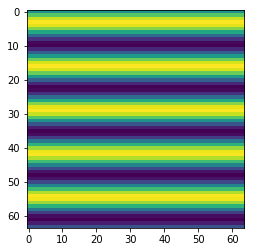

In [16]:
h, w = 64, 64
x = np.array([np.arange(0, 1, 1/h)]).T

tmp = np.sin(2*np.pi*5*x)+1 # 周波数: 5 の sin 信号に+1を足した
print(tmp.shape)
G = mlb.repmat(np.uint8(100*(tmp)), 1, w) # 列ベクトルを横方向にコピー
print(G.shape)
plt.imshow(G)

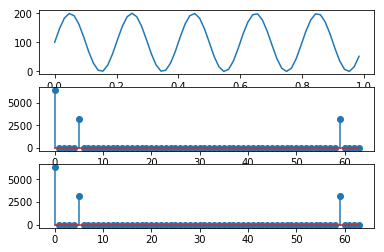

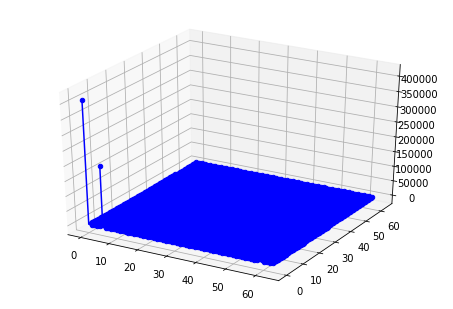

In [19]:
plt.subplot(311)
plt.plot(x, G[:,0])

plt.subplot(312)
# 列方向のスペクトルを描画
plt.stem(np.abs(sfft.fft(G[:,0])))

# 2次元全体に(まとめて)FFT
plt.subplot(313)
S = sfft.fft(G, axis=0)
plt.stem(np.abs(S[:,0])) # 0は列方向でフーリエ変換
plt.show()

S2 = sfft.fft(S, axis=1) # 行方向でフーリエ変換
cis.stem3(np.abs(S2))

### memo
#### 2次元フーリエ変換

列方向, 行方向に続けてフーリエ変換することを2次元フーリエ変換という

2次元フーリエ変換は `fft2`実行できる

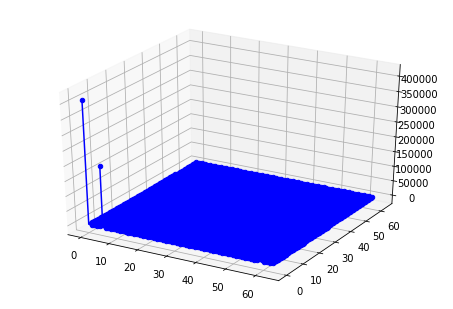

In [20]:
Z2 = sfft.fft2(G)
cis.stem3(np.abs(Z2))

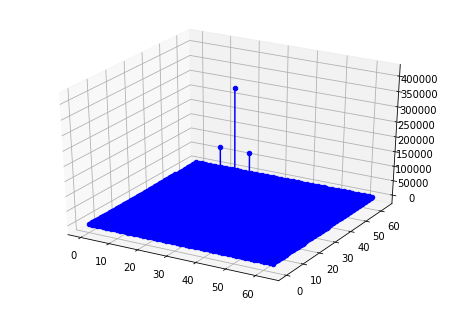

In [21]:
# 直流成分が中央にくるように
Z2shift=sfft.fftshift(Z2)
cis.stem3(np.abs(Z2shift))

## 5.3 フィルタ処理

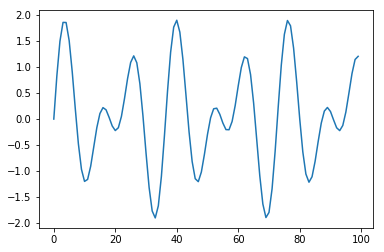

In [32]:
fs = 8000
t = np.arange(0, 1, 1/fs)
y = np.sin(2*np.pi*440*t) + np.sin(2*np.pi*660*t)
plt.plot(y[:100])
fftlen = 256
noverlap = 128
S, _, _ = mlab.specgram(y, Fs=fs, NFFT=fftlen, window=np.hanning(fftlen),
                        noverlap=noverlap, mode='complex', sides='twosided')

S = sfft.fftshift(S,axes=0)
slen = S.shape[1]
ry = np.zeros(slen*fftlen-(slen-1)*noverlap)


In [28]:
S.shape

(256, 61)

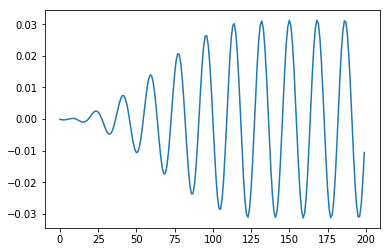

In [31]:
cutoff = 500
cind = int(cutoff/(fs/fftlen))
F = np.ones((fftlen, 1))
F[cind:-cind] = 0  # fftshiftしてるので, 中心からcutoff 分を０に
S = S*F
k1 = 0
for k in range(0, slen):
    ry[k1:k1+fftlen] = ry[k1:k1+fftlen]+np.real(sfft.ifft(S[:, k]))
    k1 = k1+noverlap

plt.plot(ry[:200])

`cind=int(cutoff/(fs/fftlen))`

+ cutoff: カットしたい周波数の最大値
+ sf/fftlen: 1index分の周波数
+ cind: 周波数領域のcutoff分のindexサイズ

#### ifftの方向
スペクトラムは列方向に周波数, 横方向にFFTした結果が順番に入ってるイメージ.
なので, ifft は縦方向に行う.

#### 出力結果
周波数500以下をカットしてるので, 周波数600の単一周波数の信号に変換できている.

### プログラム 5-3
画像データに対するフィルタの実装

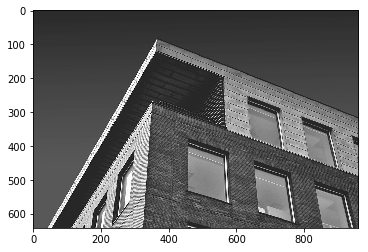

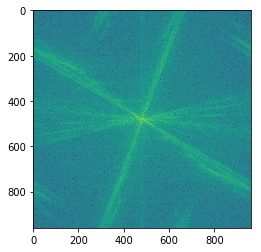

(960, 960)


In [8]:
G = cv2.imread('/root/book_files/image/building-1081868_960_720.jpg', 0)
plt.imshow(G, cmap='gray')
plt.show()

h, w = G.shape
fftsize = max(G.shape)
Z  = sfft.fftshift(sfft.fft2(G, (fftsize, fftsize))) # 2次元フーリエ変換
plt.imshow(np.log(np.abs(Z)))
plt.show()
print(Z.shape)

Zのグラフは, 強いスペクトルの部分は明るく, 弱い部分が暗く表示されている.

3本の直線はビルのエッジに対応しているらしい. (少し考えたが理由がいまいちパッっとしない)

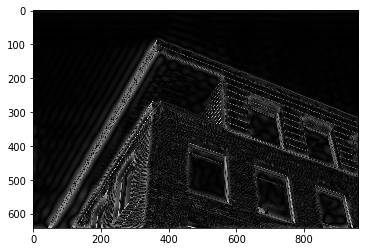

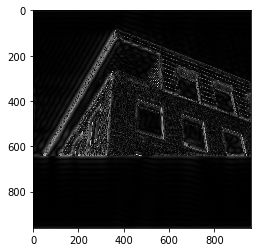

In [9]:
# HPFを設計
F=np.ones((fftsize, fftsize))
wlen = 20
# 中心部(低周波にあたる部分)を0にする.
# このフィルタを2次元フーリエ変換の結果Z にかけて, 高い周波数のみ残す
ctr = int(fftsize/2)
p1 = ctr-wlen
p2 = ctr+wlen
F[p1:p2, p1:p2] = 0

Z2 = Z*F # フィルタ適用

# 逆フーリエ変換
fG=np.uint8(np.abs(sfft.ifft2(sfft.fftshift(Z2))))
plt.imshow(fG[:h,:w],cmap='gray')
plt.show()
plt.imshow(fG,cmap='gray')
plt.show()

### プログラム 5-4
これは章末問題の方で書いてます;D